<a href="https://colab.research.google.com/github/bytewax/air-quality-sensor/blob/main/pydata_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


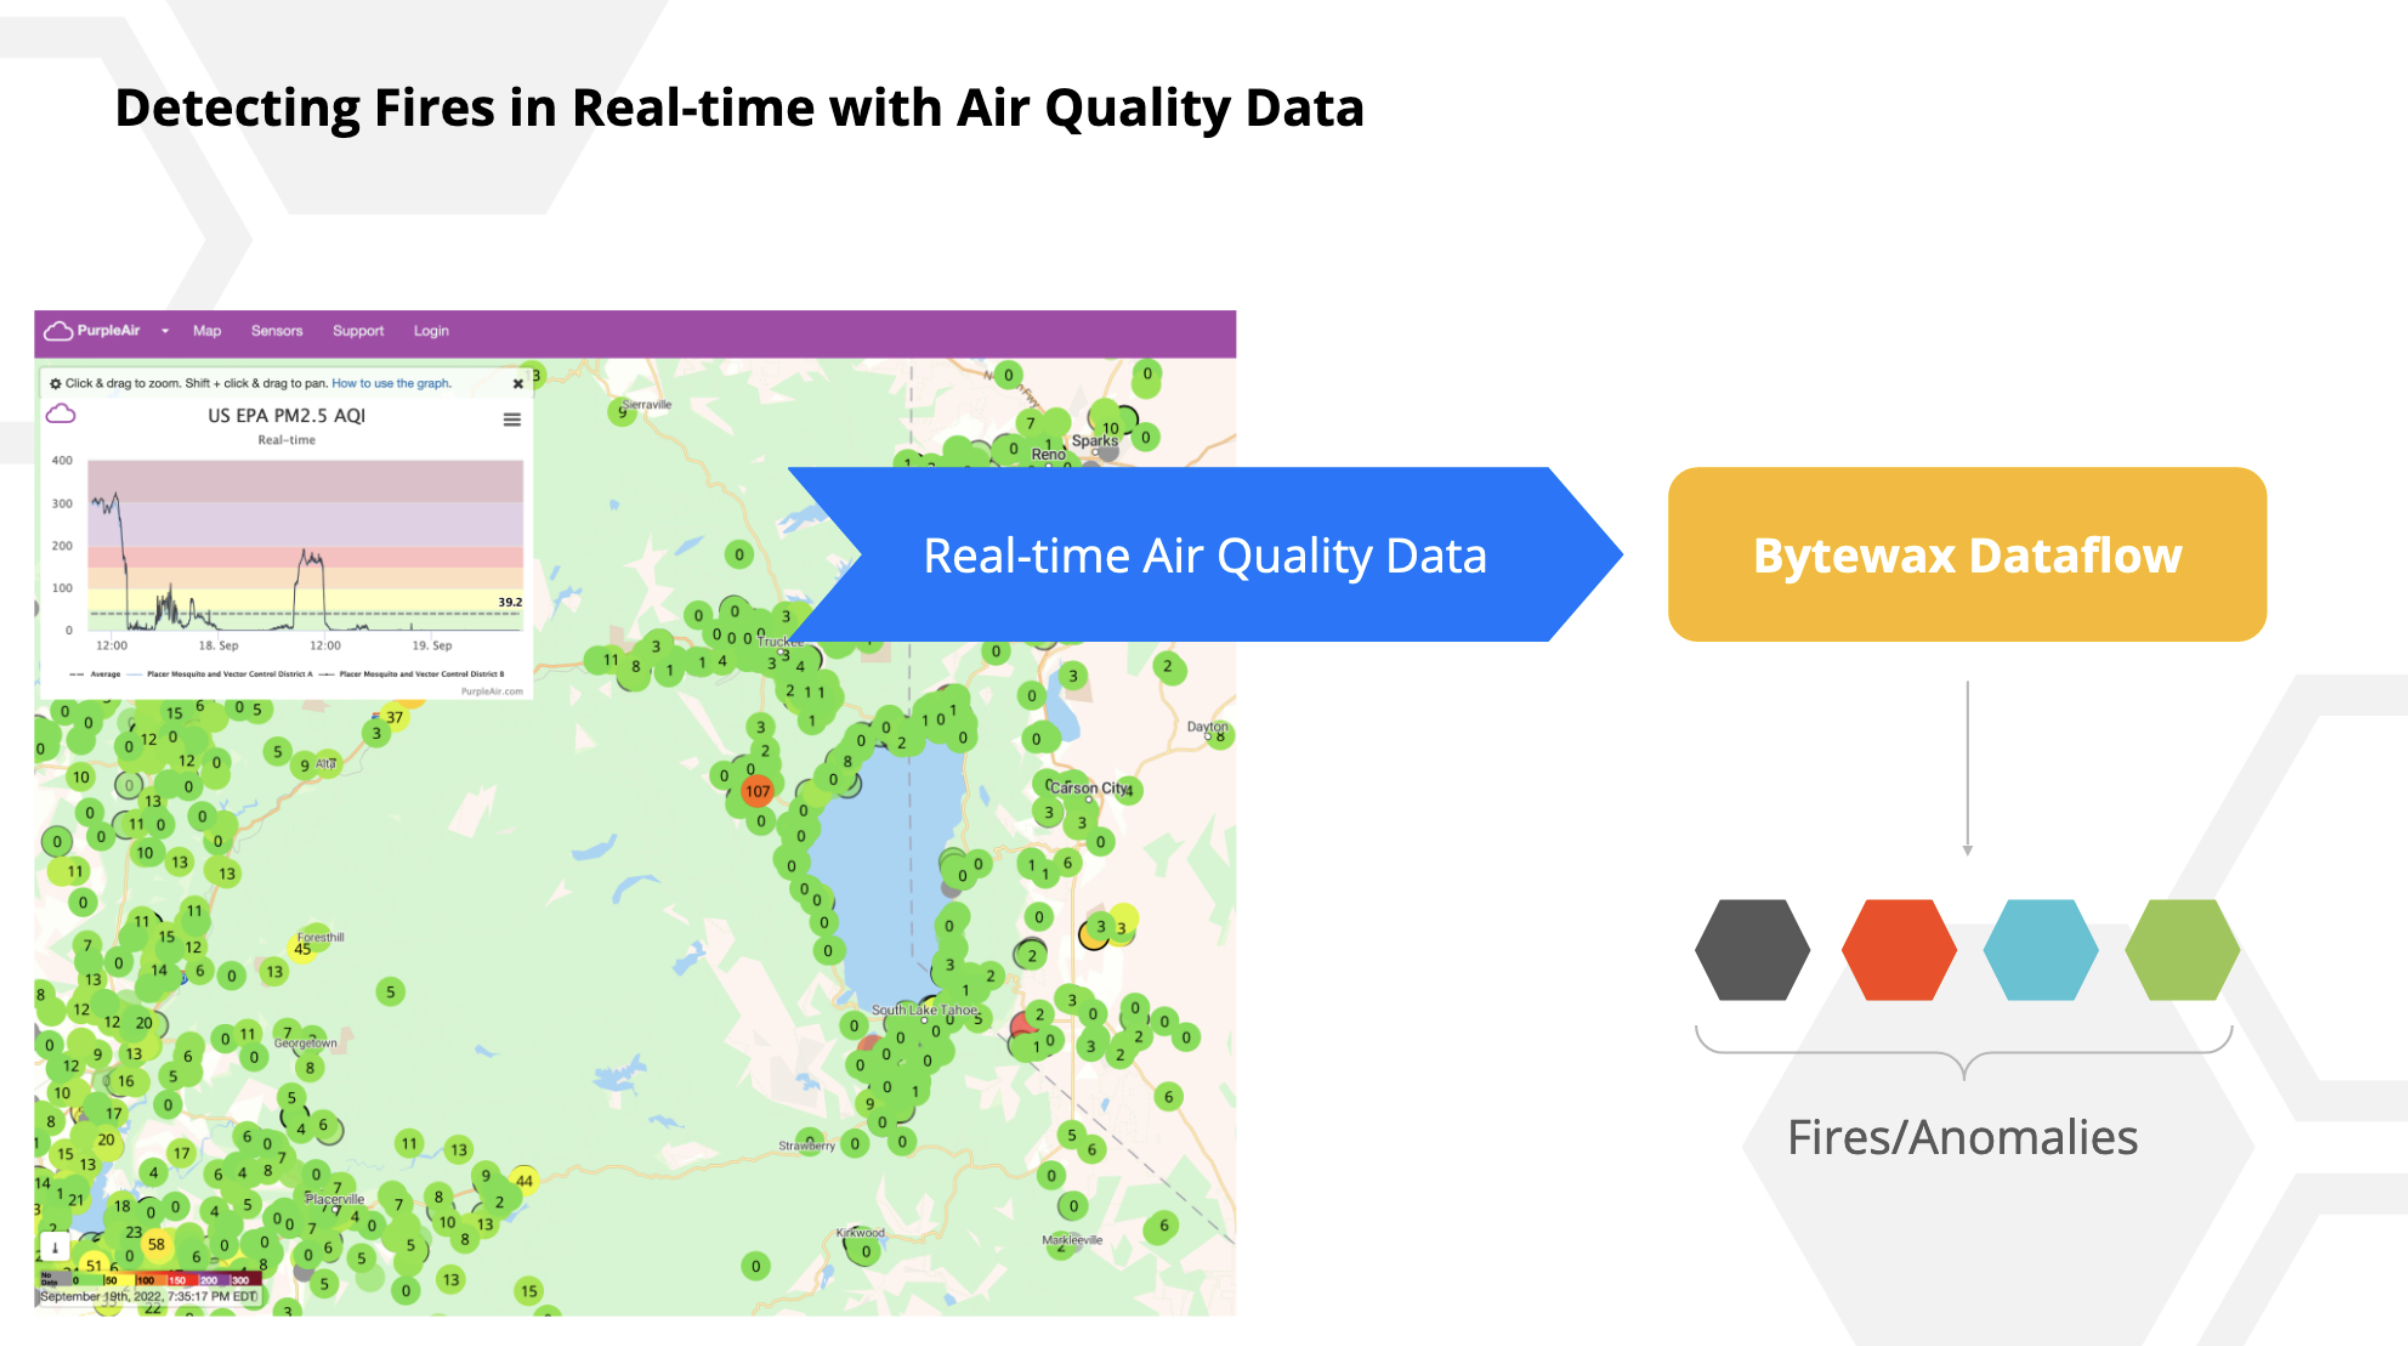


## Overview
In this tutorial we are going to simulate a real-time ML powered application that would process air quality data and then alert us of malfunctioning sensors or smoke from fire events in slack. To simulate the real-time air quality data, we will be taking a historical dataset from PurpleAir and loading it to our streaming data storage layer (Redpanda) and then we can consume that data with our streaming data processing layer (Bytewax). 

This tutorial has 3 parts:
1. Setting up the environment and downloading the data
2. Writing a Bytewax dataflow that will load the data to Redpanda and saving it as a file
3. Writing a Bytewax dataflow that will consume the data and process it to determine if there are sensor malfunctions or fires.

## Prerequisite Setup

Before we get started, we are going to need to do some work to get this notebook environment setup. We will setup the following:
* redpanda
* python dependencies
* download the dataset

Join the [community slack](https://join.slack.com/t/bytewaxcommunity/shared_invite/zt-vkos2f6r-_SeT9pF2~n9ArOaeI3ND2w) to get any help running this notebook

Give [Bytewax](https://github.com/bytewax/bytewax) a ⭐ on github 🙏

In [1]:
!wget https://github.com/bytewax/air-quality-sensor/raw/main/data/all.csv
!curl -1sLf 'https://packages.vectorized.io/nzc4ZYQK3WRGd9sy/redpanda/cfg/setup/bash.deb.sh' | sudo -E bash && \
sudo apt install redpanda -y

--2022-12-01 00:50:53--  https://github.com/bytewax/air-quality-sensor/raw/main/data/all.csv
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/bytewax/air-quality-sensor/main/data/all.csv [following]
--2022-12-01 00:50:53--  https://media.githubusercontent.com/media/bytewax/air-quality-sensor/main/data/all.csv
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102754147 (98M) [text/plain]
Saving to: ‘all.csv’

all.csv             100%[===================>]  97.99M   256MB/s    in 0.4s    

2022-12-01 00:50:53 (256 MB/s) - ‘all.csv’ saved [102754147/102754147]

Executing the  setup scr

### Starting Redpanda in the Background

With redpanda installed, we will start it in a subprocess from our notebook. This is necessary so that our cell won't wait on redpanda. Regularly you would start Redpanda or Kafka as a Daemon or Service, but we don't have that capability in a notebook environment.

In [2]:
import os
import subprocess

In [3]:
env = os.environ.copy()
p = subprocess.Popen('sudo rpk redpanda start', shell=True, env=env)

In [4]:
# check our cluster is up and running
!rpk redpanda admin brokers list

Retrying GET for error: Get "http://127.0.0.1:9644/v1/brokers": dial tcp 127.0.0.1:9644: connect: connection refused
NODE-ID  NUM-CORES  MEMBERSHIP-STATUS  IS-ALIVE  BROKER-VERSION
0        2          active             true      v22.3.4 - 5be3e8e1454ab75da3f27f571c09e625570bebb2-dirty


### Python Dependencies 

The dataflow requires bytewax, river, scipy, request and kafka-python. Geopy is only required if you are mapping your sensors to a county automatically. It is not very performant and not necessarily a good pattern to use an external request inside a streaming application because of network issues. 

In [5]:
!pip install bytewax==0.13.1 river scipy geopy==2.2.0 requests==2.28.1 kafka-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.2 MB 27.3 MB/s 
     |████████████████████████████████| 2.0 MB 66.9 MB/s 
     |████████████████████████████████| 118 kB 81.2 MB/s 
     |████████████████████████████████| 62 kB 1.8 MB/s 
     |████████████████████████████████| 246 kB 72.6 MB/s 
     |████████████████████████████████| 115 kB 20.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: geopy
    Found existing installation: geopy 1.17.0
    Uninstalling geopy-1.17.0:
      Successfully uninstalled geopy-1.17.0


### Loading Purple Air Data

The PurpleAir data was downloaded for select sensors in the Tahoe, California region using the [map download](https://www.purpleair.com/sensorlist?exclude=true&nwlat=39.35347452213327&selat=39.19729441307649&nwlng=-120.30860068106313&selng=-119.94957077185764&sensorsActive2=604800) functionality. It was then uploaded to a GitHub repository and downloaded to this colab environment so we can open it and read from it easily here. 

### Defining a Bytewax Dataflow
Below, we will write a Bytewax dataflow that will open the csv file and write the data to a Redpanda topic that we create. The dataflow will have three parts, input, serialize and capture. In the input we define how a builder function that will read the csv file. In the serialize step we will prepare the data for our Redpanda topic and in the capture part we define the Redpanda cluster and topic details.

In [6]:
%%writefile run_sensor.py
import json
import csv
import re
import argparse

from bytewax.dataflow import Dataflow
from bytewax.inputs import ManualInputConfig
from bytewax.outputs import KafkaOutputConfig
from bytewax.execution import run_main

from kafka.admin import KafkaAdminClient, NewTopic

# define the input builder function that will run on each worker
def input_builder(worker_index, worker_count, resume_state):
    state = None  # ignore recovery
    
    print(f"record limit is: {args.records}")
    max_record = args.records
    with open("all.csv", "+r") as f:
        reader_obj = csv.reader(f)
        next(reader_obj)
        record = 0
        for line in reader_obj:
            if max_record:
              if record > int(max_record):
                break
            sensor = line.pop()
            # pull out the sensor coordinates to use as the key
            match = re.match('^.+?((\-?|\+?)?\d+(\.\d+)?) \s*((\-?|\+?)?\d+(\.\d+)?).+?$',
                   sensor)
            sensor_key = ", ".join([match[1],match[4]])
            yield state, (sensor_key, line)
            record += 1

# serialize function to prep data to write to kafka
def serialize(line):
    key, data = line
    new_key_bytes = json.dumps(key).encode('utf-8')
    headers = ["created_at","entry_id","PM1.0_CF1_ug/m3","PM2.5_CF1_ug/m3","PM10.0_CF1_ug/m3","UptimeMinutes","RSSI_dbm","Temperature_F","Humidity","PM2.5_ATM_ug/m3"]
    try:
        data = {headers[i]: data[i] for i in range(len(data))}
    except IndexError:
        print(headers)
        print(data)
    return new_key_bytes, json.dumps(data).encode('utf-8')

# dataflow definition
flow1 = Dataflow()
flow1.input("file_input", ManualInputConfig(input_builder))
flow1.map(serialize)
flow1.capture(
    # StdOutputConfig()
    KafkaOutputConfig(
        brokers=["localhost:9092"],
        topic="sensor_data",
    )
)

# Use the kafka admin client to create the topic
input_topic_name = "sensor_data"
localhost_bootstrap_server = "localhost:9092"
admin = KafkaAdminClient(bootstrap_servers=[localhost_bootstrap_server])

# Create input topic
try:
    input_topic = NewTopic(input_topic_name, num_partitions=1, replication_factor=1)
    admin.create_topics([input_topic])
    print(f"input topic {input_topic_name} created successfully")
except:
    print(f"Topic {input_topic_name} already exists")

if __name__ == "__main__":
  parser = argparse.ArgumentParser(
                    prog = 'run_sensor',
                    description = 'replay historical sensor data')

  parser.add_argument('--records') 
  args = parser.parse_args()

  # run the dataflow    
  run_main(flow1)

Writing run_sensor.py


## Analyzing the Data Stream

Now that we have our prereqs set up, let's move on to the dataflow to analyze the air quality sensors for malfunctions and smoke from fires. Below is an diagram of the steps in our dataflow that will transform the raw data in kafka to alerts on malfunctioning sensors and smoke events. 

Note the different colored steps represent whether that step will be a stateful transformation or not. Each step in this diagram is Bytewax operator. Operators control the flow of the data and are passed Python functions that instruct how the data should be processed. The operators allow us to do things like filter, window, aggregate and more.

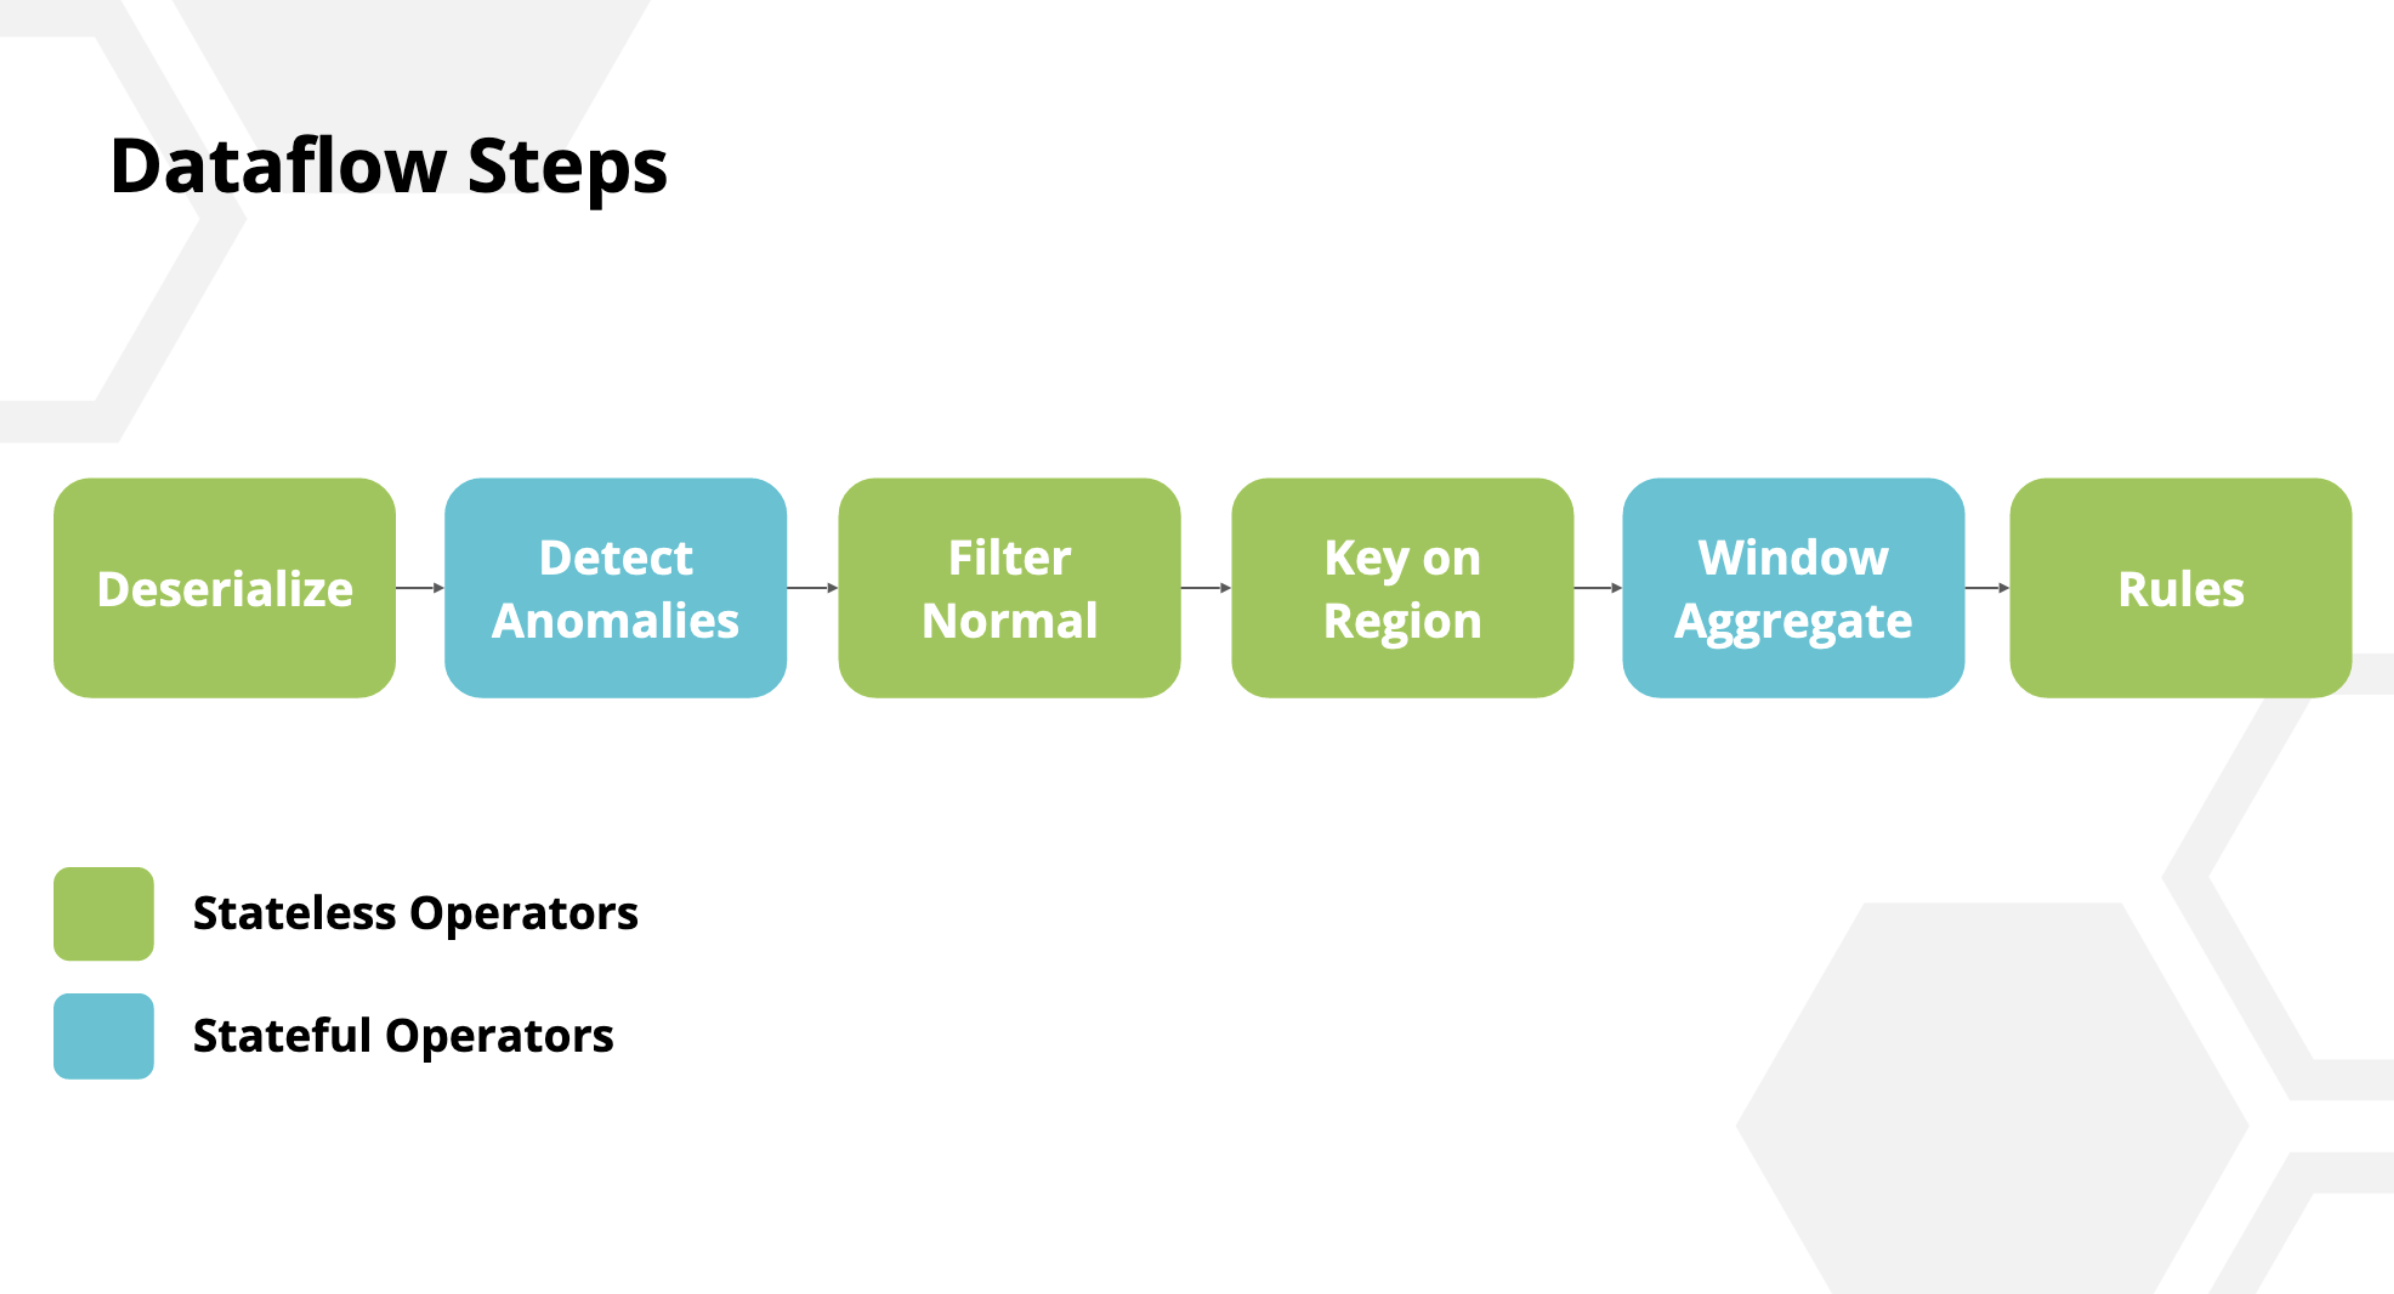


### Kafka Input

To start with, we are going to create our Dataflow object and then specify our input source. We are going to use data from Purple Air that has been loaded in to a kafka topic called `sensor_data`. The sensor location will be used as the key and the data as the payload.

For this example, since we are consuming a known, bounded stream of data, we will specify the starting offset as the beginning and the tail as false.

In [7]:
import json
import re
from datetime import datetime, timedelta, timezone
import sys
import os
from collections import defaultdict
import requests
import time

from bytewax.dataflow import Dataflow
from bytewax.inputs import KafkaInputConfig
from bytewax.outputs import ManualOutputConfig, StdOutputConfig
from bytewax.window import TumblingWindowConfig, EventClockConfig
from bytewax.execution import run_main

from scipy.stats import variation
from geopy.geocoders import Nominatim
from river import anomaly

# Put your webhook url here
WEBHOOK_URL = os.getenv("WEBHOOK_URL")

In [8]:
# Define Dataflow and input configuration
flow = Dataflow()
flow.input(
    "aqi_state", 
    KafkaInputConfig(
        brokers=["localhost:9092"], 
        topic="sensor_data",
        starting_offset = "beginning",
        tail = False
        )
    )

Next we will do some deserialization of the data in a `dataflow.map` operator.

In [9]:
# Deserialize input for processing
def deserialize(key_bytes__payload_bytes):
    key_bytes, payload_bytes = key_bytes__payload_bytes
    key = json.loads(key_bytes) if key_bytes else None
    sensor_data = json.loads(payload_bytes) if payload_bytes else None
    sensor_data['PM2.5_CF1_ug/m3'] = float(sensor_data['PM2.5_CF1_ug/m3'])
    sensor_data["created_at"] = datetime.strptime(sensor_data["created_at"], "%Y-%m-%d %H:%M:%S %Z").replace(tzinfo=timezone.utc)
    return key, sensor_data

flow.map(deserialize)

### Visualizing the data

Now that is done, we can take a look at our data by plotting it out in our notebook. This drastically slows down the dataflow because of the calls to plot at every new datum, so after running it, you should interrupt the kernel and then comment the operator out.

In [10]:
import IPython
from IPython.display import display, HTML, Javascript

In [11]:
from bytewax.outputs import TestingOutputConfig

def configure_browser_state():
  display(HTML('''
        <canvas id="myChart"></canvas>
        <script src="https://cdn.jsdelivr.net/npm/chart.js@4.0.1/dist/chart.umd.min.js"></script>
        <script src="https://cdn.jsdelivr.net/npm/chart.js/dist/chart.min.js"></script>
        <script src="https://cdn.jsdelivr.net/npm/chartjs-adapter-date-fns/dist/chartjs-adapter-date-fns.bundle.min.js"></script>
        <script>
          var ctx = document.getElementById('myChart').getContext('2d');
          const autocolors = window['chartjs-plugin-autocolors'];
          var chart = new Chart(ctx, {
              // The type of chart we want to create
              type: 'line',

              // The data for our dataset
              data: {
                  datasets: []
              },

              // Configuration options go here
              options: {
                animation: {
                  duration: 0, // general animation time
                },
                scales: {
                  x: {
                      type: 'time',
                  }
                },
                elements: {
                  point: {
                    radius : customRadius,
                    display: true
                  }
                }
              }
          });
          
          
          function addData(label, value){
            // check if dataset exists
            const exists = chart.data.datasets.findIndex(o => o.label === label)
            // if not add the dataset
            if(exists === -1) {
              const randomColor = Math.floor(Math.random()*16777215).toString(16);
              chart.data.datasets.push({label: label, data: [value], borderColor : "#" + randomColor})
            } else {
              const len = chart.data.datasets.find(o => o.label === label).data.push(value)
              // optional windowing
              if(len > 10) {
                chart.data.datasets.find(o => o.label === label).data.shift()
              }
            }

            chart.update();
          }

          function customRadius( context )
            {
              let index = context.dataIndex;
              let value = context.dataset.data[ index ];
              return value >= 50 ?
                    10 :
                    2;
            }
        </script>
        '''))

def plot(key__data):
  key, sensor_data = key__data
  time_str = '{' + f'''x: "{sensor_data['created_at']}", y: {sensor_data['PM2.5_CF1_ug/m3']}''' + '}'
  dis_str = f'''addData("{key}", {time_str})'''
  display(Javascript(dis_str))

# configure_browser_state()
# flow.inspect(plot)

# # run our dataflow simulating the historical data in the background
# env = os.environ.copy()
# p_sensor = subprocess.Popen(['python', 'run_sensor.py', '--records', '500'], env=env)
# time.sleep(2)

# out = []
# flow.capture(TestingOutputConfig(out))
# run_main(flow)


### Online ML for Anomaly Detection

We can visually analyze our data and see how there are some anomalous readings. Since our data in the chart above is all from the same region, we could probably tease out which sensors were malfunctioning versus those that when there is a smoke event. But if we wanted to do this 24/7 across thousands of regions, this might be impossible to staff a human team to do. So instead, we can use ML and heuristics. 

First we are going to leverage the River library to detect anomalies on the PM2.5 ug/m3 data. To do this, we will use a `dataflow.stateful_map` operator, which will create a new AnomalyDetector object for each key (sensor) and then for each additional datum we will score the new data and the update our model.

**note**: stateful objects are stored in worker memory and then persisted to either Kafka or SQLite for recovery.

In [12]:
# anomaly detector Class for stateful map
class AnomalyDetector:

    def __init__(self, n_trees=10, height=8, window_size=72, seed=11):
        self.detector = anomaly.HalfSpaceTrees(
                                                n_trees=n_trees,
                                                height=height,
                                                window_size=window_size,
                                                # we are using 1200 as the max for this
                                                # dataset since we know in advanced it
                                                # is the highest
                                                limits={'x': (0.0, 1200)},
                                                seed=seed
                                                )
    
    def update(self, data):
        data['score'] = self.detector.score_one({'x': data['PM2.5_CF1_ug/m3']})
        self.detector.learn_one({'x': data['PM2.5_CF1_ug/m3']})
        return self, data

flow.stateful_map(
    step_id = "anomaly_detector",
    builder = lambda: AnomalyDetector(n_trees=4, height=3, window_size=50, seed=11),
    mapper = AnomalyDetector.update,
)

### Filtering Anomalies

We have visually inspected our data and now it we want to remove the normal data to see just the data that has a score of greater than 0.7 and a PM2.5 greater than 50 since we won't care about anomalies going in the other direction from high to low. Before moving on, be sure to comment back out the DrawPlot(), inspect and run_main lines. You may need to restart the notebook at this point.

In [13]:
# threshold filtering
flow.filter(lambda x: x[1]['score']>0.7)
flow.filter(lambda x: float(x[1]['PM2.5_CF1_ug/m3'])>50)

In [14]:
# flow.capture(StdOutputConfig())

# env = os.environ.copy()
# p_sensor = subprocess.Popen(['python', 'run_sensor.py', '--records', '100000'], env=env)
# time.sleep(2)

# run_main(flow)

### Differentiating Between Smoke and Malfunction

At this point we can see we have a number of anomalous events, but we can't easily determine if they are anomalous because they are a malfunctioning sensor or if they are truly the sign of a smoke event due to nearby fire.

To determine if it is a malfunction or a smoke event, we can do some aggregation by region over time to see if the high PM2.5 persists across the region and over time. To do this, we can first convert the sensor key, which is "lat, long" to a region.

In [15]:
# reformat to group by region instead of by individual sensor
def groupby_region(loc__data):
    coordinates, data = loc__data
    # add the sensor location to the data payload
    data["coordinates"] = coordinates

    # Uncomment this code if you want to convert the lat, long to county automatically
    # locator = Nominatim(user_agent="myGeocoder")
    # location = locator.reverse(coordinates)
    # key = location.raw['address']['county']

    # since we know the location of these we will mark the key manually
    # as the generalized area we are interested in 
    key = "Lake Tahoe"
    return key, data

flow.map(groupby_region)

Now we can use another stateful operator `fold_window` to group the sensor data together over time. The windowing operators in bytewax can work on either system time or event time and they can handle late arriving data depending on what we specify. Similar to the `stateful_map` used earlier in the dataflow, for each new key, we will create an object and then for each new datum we will update the object.

In [16]:
# setup an event-time based window to be used with `created_at` field
def get_event_time(event):
    return event["created_at"]

# We need to specify a wait time that is as long as the difference between
# the oldest (2022-07-01) and the newest (2022-09-18) to ensure out of order
# events are handled correctly
cc = EventClockConfig(get_event_time, wait_for_system_duration=timedelta(hours=12))

# Manually set the start time for this dataflow, this is known for this dataset 
start_at = datetime.strptime("2022-07-18 00:00:00 UTC", "%Y-%m-%d %H:%M:%S %Z").replace(tzinfo=timezone.utc)
wc = TumblingWindowConfig(start_at=start_at, length=timedelta(hours=12))

# Anomalies class to be used in the event-time window
class Anomalies:

    def __init__(self):
        self.sensors = []
        self.times = []
        self.values = []

    def update(self, event):
        self.sensors.append(event["coordinates"])
        self.times.append(event["created_at"])
        self.values.append(float(event["PM2.5_CF1_ug/m3"]))

        return self

flow.fold_window("count_sensors", cc, wc, Anomalies, Anomalies.update)

Here we use some statistics and heuristics on the accumulated window of data to infer whether the data was a malfunctioning sensor or a smoke event.

In [ ]:
# Calculate some statistics and use rules to separate smoke events from malfunctions
def convert(key__anomalies):
    key, anomalies = key__anomalies
    
    # check is more than one sensor anomalous
    count_sensors = len(set(anomalies.sensors))
    count_anomalies = len(anomalies.values)
    min_event = min(anomalies.times)
    max_pm25 = max(anomalies.values)
    sensors = set(anomalies.sensors)
    malfunction = False
    anom_variance = None

    if count_sensors < 2:
        if count_anomalies < 10:
            malfunction = True
        else:
            # simplification, if there is wild variance in the data it is 
            # possibly a false positive
            anom_variance = variation(anomalies.values)
            if anom_variance > 0.3:
                malfunction = True

    return (key, {
            "sensors": sensors,
            "count_sensors": count_sensors,
            "count_anomalies": count_anomalies,
            "anomalies": anomalies.values,
            "min_event": min_event,
            "max_pm25": max_pm25,
            "variance": anom_variance,
            "malfunction": malfunction
            })

flow.map(convert)

### Data Output

Bytewax has some native connectors that we have developed in house, but it is also possible to leverage Python client libraries in an output builder. To write data from the dataflow to different downstream systems. In this dataflow, we are writing to slack with the information about the malfunctioning sensors and potential fires.

In this example, we are running a single thread, single process dataflow since we are doing some investigation and iterating on the example, but in production I could then scale up this data flow to multiple workers to match the parallelization of the kafka stream.

**Before this will work, you will need to set your `WEBHOOK_URL` environment variable.**

In [ ]:
# output smoke event data to slack channel
def output_builder(worker_index, worker_count):
    
    def send_to_slack(key__sensor_data):
        location, sensor_data = key__sensor_data
        if sensor_data['malfunction']:
            message = f'''In {location} was a malfunctioning sensor at location
                            {sensor_data['sensors']} at {sensor_data['min_event']}'''
            title = (f"Malfunctioning Sensor")
        else:
            message = f'''In {location} there is a suspected smoke event from a fire reported 
                        by sensors at {sensor_data['sensors']} at {sensor_data['min_event']}'''
            title = (f"Suspected Smoke Event")
        slack_data = {
            "username": "Air Quality Bot",
            "icon_emoji": ":satellite:",
            "channel" : "#hacking-on-bytewax",
            "attachments": [
                {
                    "color": "#9733EE",
                    "fields": [
                        {
                            "title": title,
                            "value": message,
                            "short": "false",
                        }
                    ]
                }
            ]
        }
        byte_length = str(sys.getsizeof(slack_data))
        headers = {'Content-Type': "application/json", 'Content-Length': byte_length}
        response = requests.post(WEBHOOK_URL, data=json.dumps(slack_data), headers=headers)
        if response.status_code != 200:
            raise Exception(response.status_code, response.text)

    return send_to_slack

flow.capture(
    # StdOutputConfig()
    ManualOutputConfig(output_builder)
    )

In [ ]:
run_main(flow)

### Scaling and Recovery

Bytewax dataflows are data parallel, so they scale across IO as demonstrated in the image below.



We have now run our dataflow on a single worker in a single process and although we are happy with the results, it is quite CPU intensive, so let's see if we can speed it up by increasing the number of processes. Let's look at how we can scale it up and add recovery. 

**This shouldn't be run in a Jupyter notebook context.**

In [ ]:
# recovery_config = KafkaRecoveryConfig(
#     ["localhost:9092"],
#     "sensor_data_recovery",
#     )
# spawn_cluster(
#         flow,
#         recovery_config=recovery_config,
#         proc_count=3,
#     )